In [1]:
import numpy as np
from matplotlib import pyplot as plt
import yaml
from hsa_hopper.collocation import PiecewiseInterpolation
import hsa_hopper.dynamics
from hsa_hopper.controller import HopController
from hsa_hopper.kinematics import KinematicParameters, forward_kinematics

In [2]:
x_td = -35*np.pi/180
with open('no_hsa_hop_start.yaml') as f: 
    startup_params = yaml.load(f,yaml.Loader)
with open('no_hsa_stance_controller.yaml') as f:
    stance_params = yaml.load(f,yaml.Loader)
kp = [
    startup_params['Kx'],
    5.,
    stance_params['Kx']
]
kd = [
    .01,
     .01,
    .01
]
x0 = [
    startup_params['x0'],
    stance_params['x0']-1*np.pi/180,
    stance_params['x0']
]
u_interp = [
    PiecewiseInterpolation.make_from_dict(startup_params['u_interp']),
    None,
    PiecewiseInterpolation.make_from_dict(stance_params['u_interp'])
]
controller = HopController(kp,kd,x0,u_interp,x_td)

In [3]:
"""
Simulation method - simple forward euler
"""
from scipy.optimize import root_scalar
def euler_sim(
    initial_state,
    initial_mode,
    t0,
    tf,
    dt,
    dynamics_params,
    kinematic_params,
    controller,
    restitution = .8
):
    state = [initial_state]
    mode = [initial_mode]
    t = [t0]
    while t[-1] < tf:
        # print(controller.mode)
        if mode[-1] == HopController._STANCE or mode[-1] == HopController._STARTUP:
            # controller output
            _kp, _kd, _x0, _u = controller.output(t[-1])
            dynamics_params.m = robot_mass
            dynamics_params.bx = _kd
            dynamics_params.Kx = _kp
            dynamics_params.x0 = _x0
            
            # stance dynamics
            x_accel = hsa_hopper.dynamics.evaluate(
                state[-1][0],
                state[-1][1],
                _u,
                dynamics_params
            )
  
            _x = state[-1][0]+state[-1][1]*dt + .5*x_accel*dt**2
            _xdot = state[-1][1] + x_accel*dt
            f, df = forward_kinematics(kinematic_params, _x, jacobian=True)
            _y, _ydot = f[0], df[0]*_xdot
            _t = t[-1]+dt
            controller.update(_x, _t)
            mode.append(controller.mode)
            state.append(np.array([_x,_xdot,_y,_ydot]))
            t.append(_t)
                
        elif mode[-1] == HopController._FLIGHT:
            # controller output
            _kp, _kd, _x0, _u = controller.output(t[-1])
            dynamics_params.bx = _kd
            dynamics_params.Kx = _kp
            dynamics_params.x0 = _x0
            dynamics_params.m = 0
            dynamics_params.by = 0
            x_accel = hsa_hopper.dynamics.evaluate(
                state[-1][0],
                state[-1][1],
                _u,
                dynamics_params
            )
            _x = state[-1][0] + state[-1][1]*dt + .5*x_accel*dt**2
            _xdot = state[-1][1] + x_accel*dt
            _y = state[-1][2]+dt*state[-1][3]-.5*9.81*dt**2
            _ydot = state[-1][3]-dt*9.81
            _t = t[-1]+dt
            controller.update(_x, _t)
            mode.append(controller.mode)
            state.append(np.array([_x,_xdot,_y,_ydot]))
            t.append(_t)
    return state, mode, t
                
    

In [4]:
"""
Set up intiial conditions, simulation parameters
"""
kinematic_params = KinematicParameters(.07,.15,.3,0.)
robot_mass = 1.2
motor_inertia = .01
dynamics_params = hsa_hopper.dynamics.DynamicsParameters(
    robot_mass,
    motor_inertia,
    None,
    0.,
    None,
    None,
    kinematic_params
)
t0 = 0.
tf = .35
dt = 1e-3
controller.initialize(t0)
x = -15*np.pi/180
y = forward_kinematics(kinematic_params, x)[0]
initial_state = np.array([x,0.,y,0])
initial_mode = controller.mode
print(initial_mode)
state, mode, time = euler_sim(initial_state, initial_mode, t0, tf, dt, dynamics_params, kinematic_params, controller)
state = np.vstack(state)

0


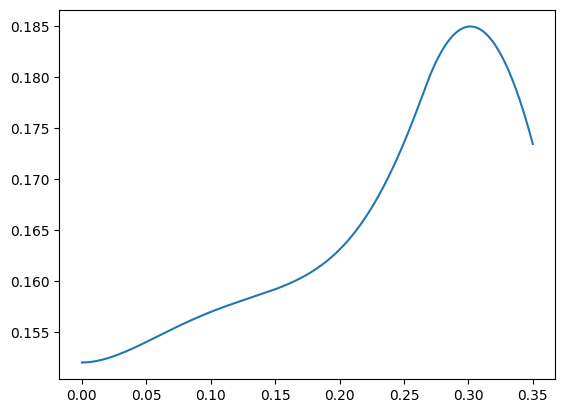

In [5]:
# plt.plot(time, state[:,0])
# plt.plot(time, np.array(mode)*.0)
plt.plot(time,state[:,2])
# plt.plot(time,state[:,0]*180/np.pi)
# print(controller.mode)


In [6]:
forward_kinematics(kinematic_params,-35*np.pi/180)

array([0.17875789, 0.12124211])